In [1]:
import numpy as np
import random
import gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

import seaborn as sns
from IPython.display import clear_output
import time
import copy

In [2]:
env = gym.make('Taxi-v3')

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
state = env.reset()
# env.s
# env.nA

In [ ]:
env.observation_space

Discrete(500)

In [ ]:
print(list(env.decode(state)))

[0, 2, 3, 1]


In [ ]:
num_states = env.observation_space

In [ ]:
num_states

Discrete(500)

In [ ]:
env.reset()

123

In [ ]:
env.action_space

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Discrete(6)

In [ ]:
next_state, reward, done, prob = env.step(0)

In [ ]:
env.reset()

341

In [ ]:
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    return np.argmax(q_values[state])
  else:
    return random.randint(0,q_values.shape[-1]-1)

In [ ]:
nO = 4 #number of options
goal = [[0,0],[0,4],[4,0],[4,3]]

def Option_0(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[0][0] and y==goal[0][1]):
      optdone = True 
      if pas == 0:
        optact = 4
      elif drop == 0:
        optact = 5 
      else:   
        optact = 1
  else:
    optact = egreedy_policy(Q[0], 5*x+y, epsilon=eps) 
  return [optact,optdone]

def Option_1(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[1][0] and y==goal[1][1]):
      optdone = True 
      if pas == 1:
        optact = 4
      elif drop == 1:
        optact = 5 
      else:   
        optact = 1
  else:
    optact = egreedy_policy(Q[1], 5*x+y, epsilon=eps) 
  return [optact,optdone]

def Option_2(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[2][0] and y==goal[2][1]):
      optdone = True 
      if pas == 2:
        optact = 4
      elif drop == 2:
        optact = 5 
      else:   
        optact = 0
  else:
    optact = egreedy_policy(Q[2], 5*x+y, epsilon=eps) 
  return [optact,optdone]

def Option_3(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[3][0] and y==goal[3][1]):
      optdone = True 
      if pas == 3:
        optact = 4
      elif drop == 3:
        optact = 5 
      else:   
        optact = 0
  else:
    optact = egreedy_policy(Q[3], 5*x+y, epsilon=eps) 
  return [optact,optdone]

In [ ]:
#### SMDP Q-Learning 

rewards_SMDP = []
steps_SMDP = []

gamma = 0.9
alpha = 0.1

nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_SMDP = np.zeros((nPas*nDrop,nO)) #Q-Table 
updates_SMDP = np.zeros((nPas*nDrop,nO))

#no. of states = 25 and no. actions that moves the taxi = 4
Qopt = [np.zeros((25,4)) for i in range(nO)] #Q-values for primitive actions in each option

eps = 0.01
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5
count = 0
Neps = 1500


for i in range(Neps):
    state = env.reset()    
    done = False
    tot_rew = 0
    tot_steps = 0 
    
    while not done:
        
        # Choose action       
        x,y,pas,drop = env.decode(state) 
        subState = nDrop*pas+drop
        option = egreedy_policy(q_values_SMDP, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)
        reward_bar = 0
        optdone = False
        move = 0
        prev = state  

        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        optdone = False
        while not optdone and not done:
          if option==0:
            optact,optdone = Option_0(env,state,Qopt,eps)
          elif option==1:
            optact,optdone = Option_1(env,state,Qopt,eps)
          elif option==2:
            optact,optdone = Option_2(env,state,Qopt,eps)
          else:
            optact,optdone = Option_3(env,state,Qopt,eps)

          
          [x,y,_,_]=  list(env.decode(state))  

          next_state, reward, done,_ = env.step(optact)
          [x1,y1,_,_]=  list(env.decode(next_state)) 
          reward_bar = gamma*reward_bar + reward
          move += 1
          tot_rew+=reward
          tot_steps += 1

          reward_eff = reward
          if optdone:
            reward_eff = 20
          if optact<4:  
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_eff + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state

          

        _,_,pas,drop = env.decode(state) 
        subState = nDrop*pas+drop

        _,_,pas,drop = env.decode(prev) 
        subPrev = nDrop*pas+drop

        q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        updates_SMDP[subPrev, option] += 1
    rewards_SMDP.append(tot_rew)
    steps_SMDP.append(tot_steps)

Text(0.5, 1.0, 'SMDP Q-learning')

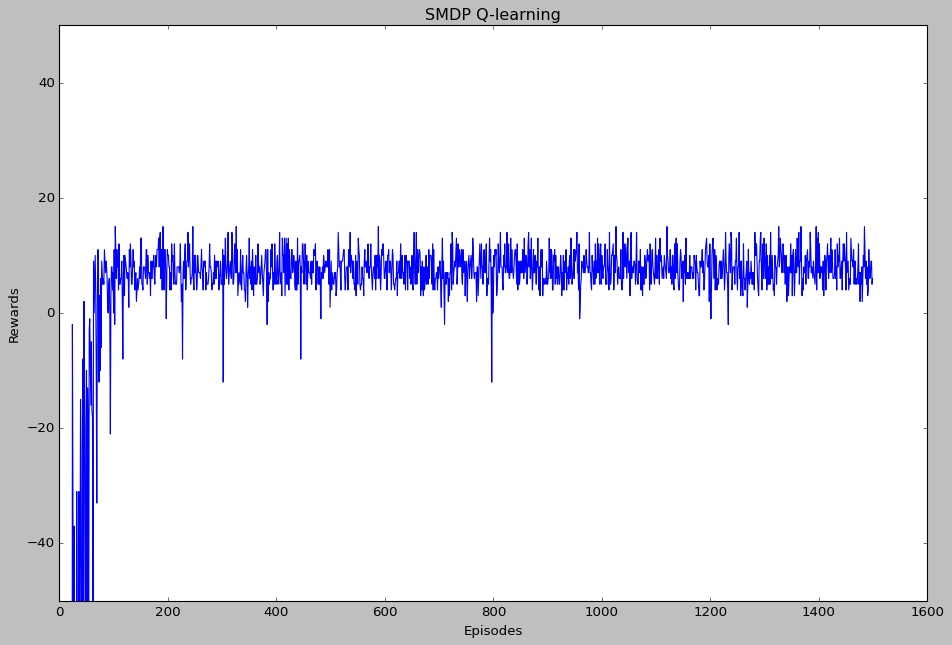

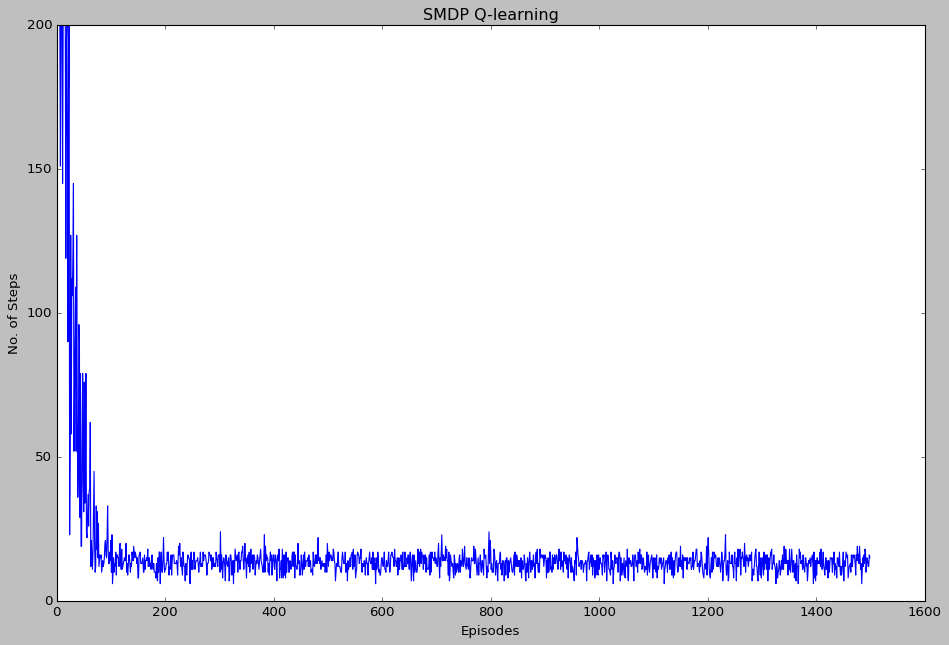

In [ ]:
plt.style.use('classic')
plt.figure(figsize = (14,9))
plt.plot(rewards_SMDP)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.ylim(-50,50)
plt.title('SMDP Q-learning')

plt.figure(figsize = (14,9))
plt.plot(steps_SMDP)
plt.xlabel('Episodes')
plt.ylabel('No. of Steps')
plt.title('SMDP Q-learning')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


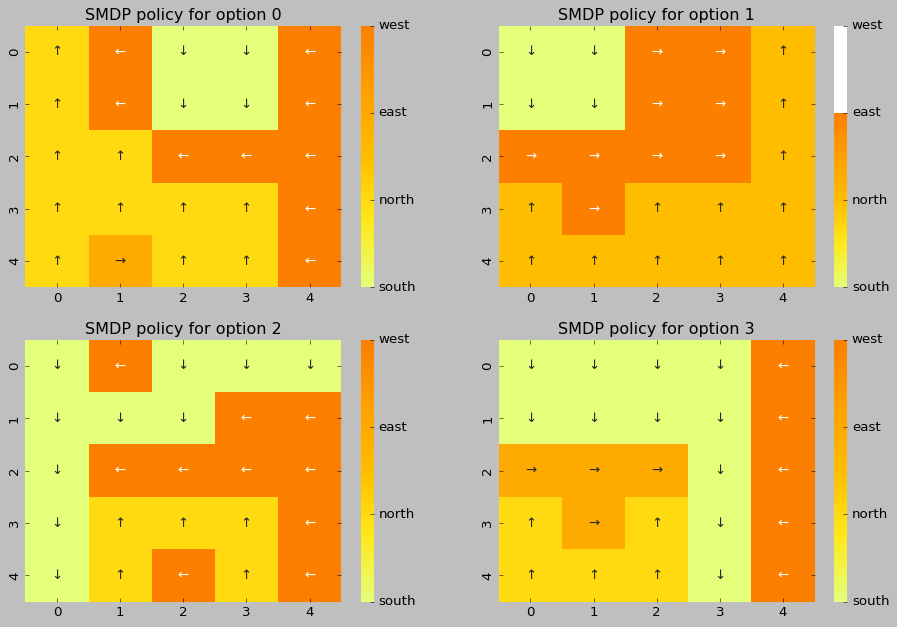

In [ ]:
figure, axis = plt.subplots(2,2,figsize=(14,9))
for i in range(2):
  for j in range(2):
    labels = {0:'↓',1:'↑', 2:'→', 3:'←'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='',cmap='Wistia')
    axis[i,j].set_title("SMDP policy for option {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])

#Intra-Option Q-Learning

In [ ]:
def Sub(state, nPas = nPas, nDrop = nDrop):
  _,_,pas,drop = env.decode(state) 
  subState = nDrop*pas+drop 
  return subState 

In [ ]:
## Intra Option Q-Learning

rewards_intra_options = []
steps_intra_options = []

gamma = 0.9
alpha = 0.1

nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_intra_option = np.zeros((nPas*nDrop,nO)) #Q-values for options
updates_intra_option = np.zeros((nPas*nDrop,nO))

#no. of states = 25 and no. actions that moves the taxi = 4
Qopt = [np.zeros((25,4)) for i in range(nO)] #Q-values for primitive actions


eps = 0.01
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

count = 0
Neps = 1500


for i in range(Neps):
    state = env.reset()    
    done = False
    tot_rew = 0
    tot_steps = 0

    
    while not done:
        
        
        _,_,pas,drop = env.decode(state) 
        subState = nDrop*pas+drop      
        action = egreedy_policy(q_values_intra_option, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)
        

        option = action
        optdone = False
        prev = state  
        while not optdone and not done:
            
            
            if option==0:
              optact,optdone = Option_0(env,state,Qopt,eps)
            elif option==1:
              optact,optdone = Option_1(env,state,Qopt,eps)
            elif option==2:
              optact,optdone = Option_2(env,state,Qopt,eps)
            else:
              optact,optdone = Option_3(env,state,Qopt,eps)
            next_state, reward, done,_ = env.step(optact)
            
            tot_steps += 1

            
            #Option Policy Learning
            [x,y,_,_]=  list(env.decode(state)) 
            [x1,y1,_,_]=  list(env.decode(next_state)) 

            
            tot_rew+=reward
            reward_eff = reward
            if optdone:
              reward_eff = 20
            if optact<4:  
              Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_eff + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])



            #finding all options giving same action call
            
            for o in range(nO):
              if o==0:
                optact_o,optdone_o = Option_0(env,state,Qopt,eps)
              elif o==1:
                optact_o,optdone_o = Option_1(env,state,Qopt,eps)
              elif o==2:
                optact_o,optdone_o = Option_2(env,state,Qopt,eps)
              else:
                optact_o,optdone_o = Option_3(env,state,Qopt,eps)
              
              if optact_o == optact:
                if optdone_o:
                  q_values_intra_option[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_intra_option[Sub(next_state), :]) - q_values_intra_option[Sub(state), o])
                else:
                  q_values_intra_option[Sub(state), o] += alpha*(reward + gamma*q_values_intra_option[Sub(next_state), o] - q_values_intra_option[Sub(state), o]) 

                updates_intra_option[Sub(state), o] += 1
            state = next_state 
        
    rewards_intra_options.append(tot_rew)
    steps_intra_options.append(tot_steps)


Text(0.5, 1.0, 'Intra option Q-learning')

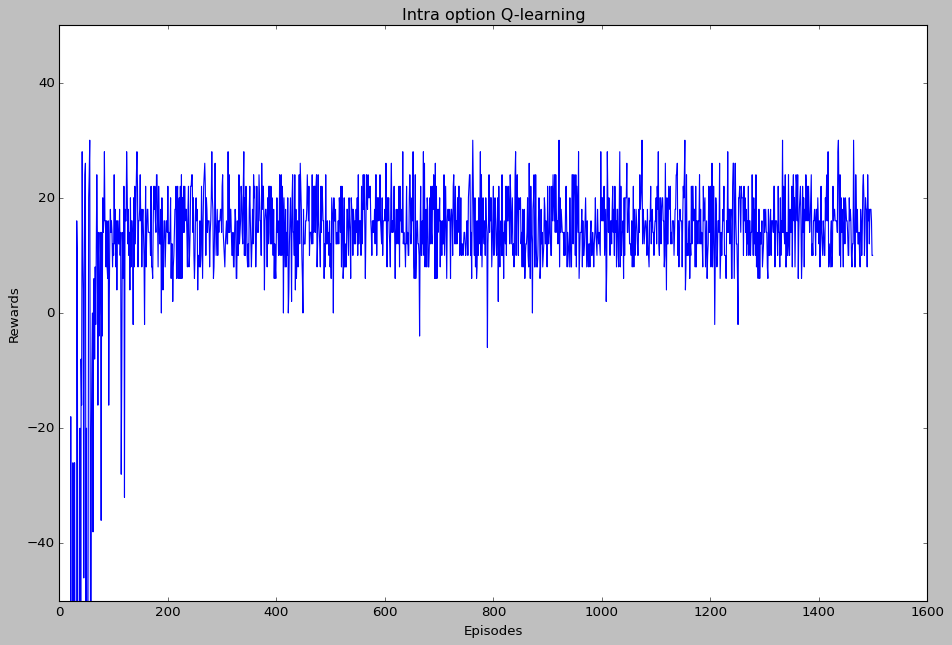

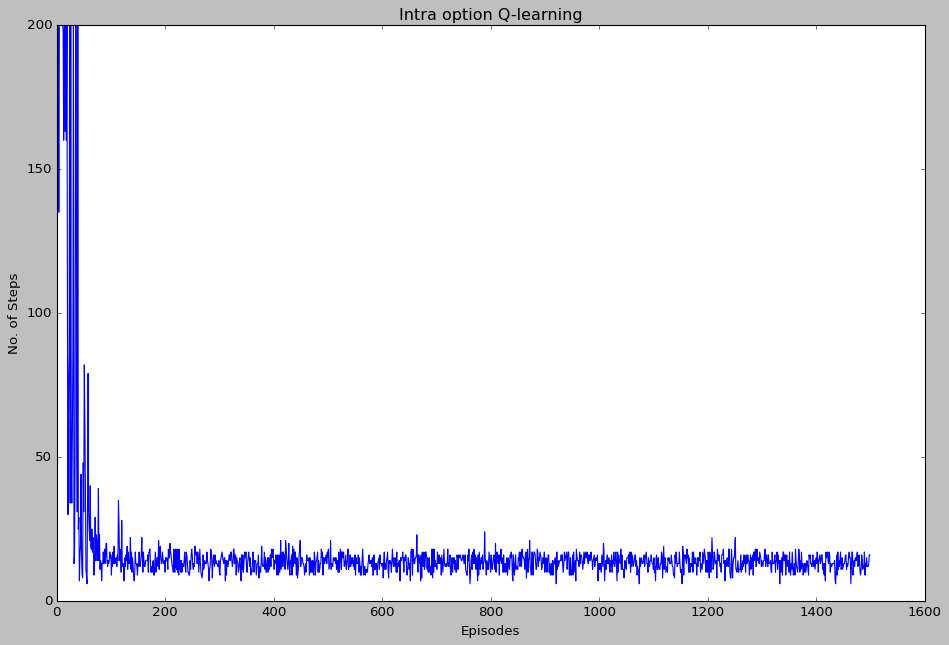

In [ ]:
plt.style.use('classic')
plt.figure(figsize = (14,9))
plt.plot(rewards_intra_options)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.ylim(-50,50)
plt.title('Intra option Q-learning')

plt.figure(figsize = (14,9))
plt.plot(steps_intra_options)
plt.xlabel('Episodes')
plt.ylabel('No. of Steps')
plt.title('Intra option Q-learning')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


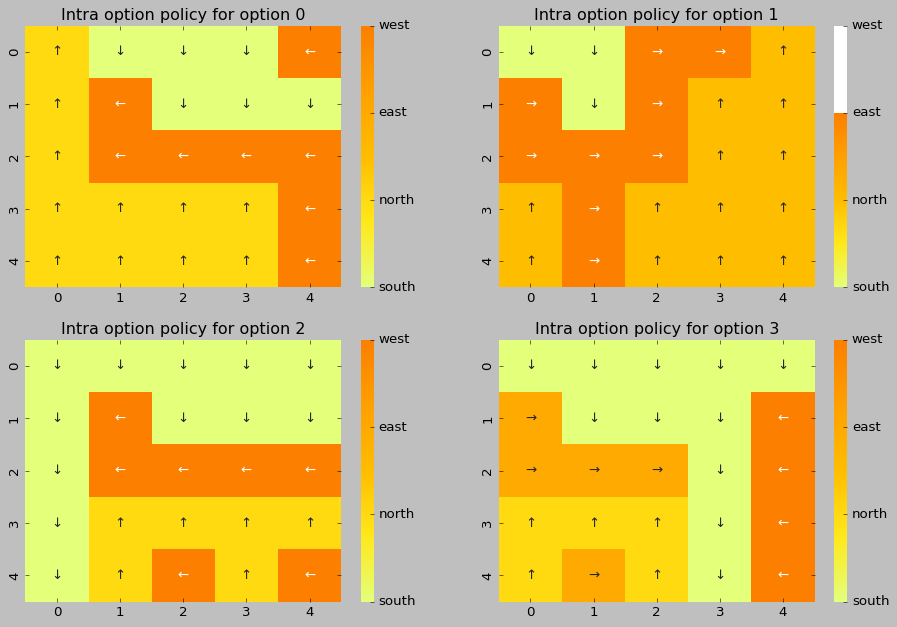

In [ ]:
figure, axis = plt.subplots(2,2,figsize=(14,9))
for i in range(2):
  for j in range(2):
    labels = {0:'↓',1:'↑', 2:'→', 3:'←'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='',cmap='Wistia')
    axis[i,j].set_title("Intra option policy for option {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])

In [ ]:
print(np.mean(rewards_SMDP[200:1400]),np.mean(rewards_intra_options[200:1400]))

7.695833333333334 15.155


#Alternate set of options for solving the environment

In [5]:
def egreedy_policy_smdp(q_values,state,pres,epsilon):
  if pres==0:
    poss_opt = [4,5]
  elif pres==1:
    poss_opt = [0,2]
  else:
    poss_opt = [1,3]
  
  if q_values[state].any() and random.random() > epsilon:
    return poss_opt[np.argmax(np.take(q_values[state],poss_opt))]
    
  else:
    return poss_opt[random.randint(0,1)]

def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    return np.argmax(q_values[state])
  else:
    return random.randint(0,q_values.shape[-1]-1)

In [6]:
nO = 6 #number of options
goal = [[0,0],[0,4],[4,0],[4,3],[2,1],[2,3]]

def Option_0(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[0][0] and y==goal[0][1]):
      optdone = True 
      if pas == 0:
        optact = 4
      elif drop == 0:
        optact = 5 
      else:   
        optact = 1
  else:
    optact = egreedy_policy(Q[0], 5*x+y, epsilon=eps) 
  return [optact,optdone]

def Option_1(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[1][0] and y==goal[1][1]):
      optdone = True 
      if pas == 1:
        optact = 4
      elif drop == 1:
        optact = 5 
      else:   
        optact = 1
  else:
    optact = egreedy_policy(Q[1], 5*x+y, epsilon=eps) 
  return [optact,optdone]

def Option_2(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[2][0] and y==goal[2][1]):
      optdone = True 
      if pas == 2:
        optact = 4
      elif drop == 2:
        optact = 5 
      else:   
        optact = 0
  else:
    optact = egreedy_policy(Q[2], 5*x+y, epsilon=eps) 
  return [optact,optdone]

def Option_3(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[3][0] and y==goal[3][1]):
      optdone = True 
      if pas == 3:
        optact = 4
      elif drop == 3:
        optact = 5 
      else:   
        optact = 0
  else:
    optact = egreedy_policy(Q[3], 5*x+y, epsilon=eps) 
  return [optact,optdone]

def Option_4(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)  
  env2=copy.deepcopy(env)
  optact = egreedy_policy(Q[4], 5*x+y, epsilon=eps)

  next_state,_,_,_=env2.step(optact)
  x1,y1,_,_=env2.decode(next_state)
  if (x1==goal[4][0] and y1==goal[4][1]):

    optdone=True

  return [optact,optdone]

def Option_5(env,state,Q,eps=0.1):
  optdone = False
  x,y,pas,drop=env.decode(state)  
  env2=copy.deepcopy(env)
  optact = egreedy_policy(Q[5], 5*x+y, epsilon=eps)
   
  next_state,_,_,_=env2.step(optact)
  x1,y1,_,_=env2.decode(next_state)
  if (x1==goal[5][0] and y1==goal[5][1]):

    optdone=True

  return [optact,optdone]

In [7]:
env=gym.make('Taxi-v3')

In [36]:
#### SMDP Q-Learning 
from tqdm import tqdm
rewards_SMDP = []
steps_SMDP = []
nO=6
gamma = 0.9
alpha = 0.005
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_SMDP = np.zeros((nPas*nDrop*3,nO)) #Q-Table 
updates_SMDP = np.zeros((nPas*nDrop*3,nO))

#no. of states = 25 and no. actions that moves the taxi = 4
Qopt = [np.zeros((25,4)) for i in range(nO)] #Q-values for primitive actions in each option

eps = 0.01
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.6
count = 0
Neps = 500


for i in tqdm(range(Neps)):

    state = env.reset()    
    done = False
    tot_rew = 0
    tot_steps = 0 
    
    while not done:
        
        # Choose action       
        x,y,pas,drop = env.decode(state) 
        if x==2:
          if y==1:
            pres=1
          elif y==3:
            pres=2
          else:
            pres=0
        else:
          pres=0
        subState = (nDrop*pas+drop)*3+pres
        option = egreedy_policy_smdp(q_values_SMDP, subState,pres,epsilon=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)
        reward_bar = 0
        optdone = False
        move = 0
        prev = state  

        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        optdone = False
  
        while not optdone and not done:
          if option==0:
            optact,optdone = Option_0(env,state,Qopt,eps)
          elif option==1:
            optact,optdone = Option_1(env,state,Qopt,eps)
          elif option==2:
            optact,optdone = Option_2(env,state,Qopt,eps)
          elif option==3:
            optact,optdone = Option_3(env,state,Qopt,eps)
          elif option==4:
            optact,optdone = Option_4(env,state,Qopt,eps)
          else:
            optact,optdone = Option_5(env,state,Qopt,eps)

          
          [x,y,_,_]=  list(env.decode(state))  

          next_state, reward, done,_ = env.step(optact)
          [x1,y1,_,_]=  list(env.decode(next_state)) 
          reward_bar = gamma*reward_bar + reward
          move += 1
          tot_rew+=reward
          tot_steps += 1

          reward_eff = reward
          if optdone:
            reward_eff = 20
          if optact<4:  
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_eff + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state

          

        x,y,pas,drop = env.decode(state)
        if x==2:
          if y==1:
            pres=1
          elif y==3:
            pres=2
          else:
            pres=0
        else:
          pres=0
        subState = (nDrop*pas+drop)*3+pres

        if x==2:
          if y==1:
            poss_opt = [0,2]
          elif y==3:
            poss_opt = [1,3]
          else:
            poss_opt = [4,5]
        else:
          poss_opt = [4,5]


        x,y,pas,drop = env.decode(prev)
        if x==2:
          if y==1:
            pres=1
          elif y==3:
            pres=2
          else:
            pres=0
        else:
          pres=0
        subPrev = (nDrop*pas+drop)*3+pres


        q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max([q_values_SMDP[subState,poss_opt[0]],q_values_SMDP[subState,poss_opt[1]]]) - q_values_SMDP[subPrev, option])
        updates_SMDP[subPrev, option] += 1
    rewards_SMDP.append(tot_rew)
    steps_SMDP.append(tot_steps)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


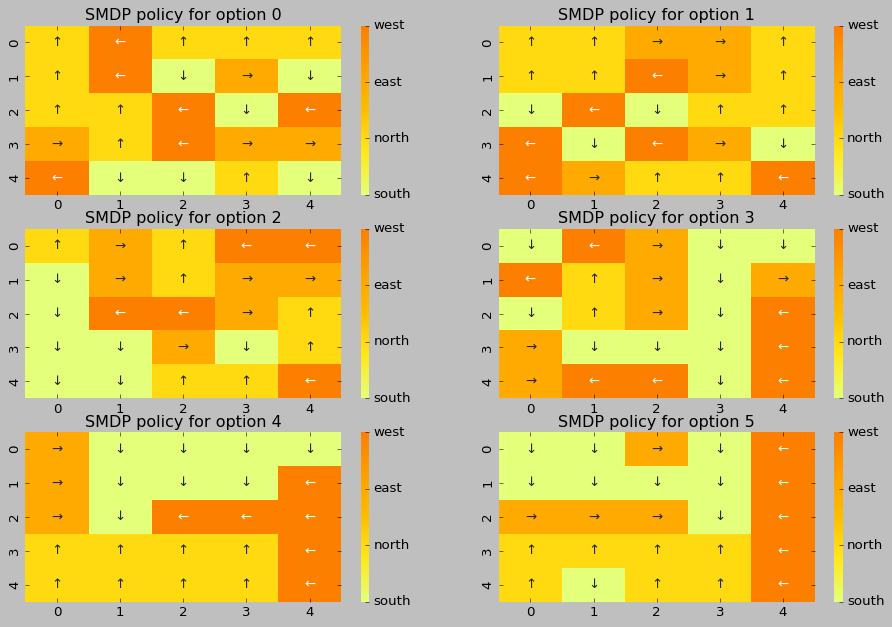

In [39]:
figure, axis = plt.subplots(3,2,figsize=(14,9))
for i in range(3):
  for j in range(2):
    labels = {0:'↓',1:'↑', 2:'→', 3:'←'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='',cmap='Wistia')
    axis[i,j].set_title("SMDP policy for option {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])

Text(0.5, 1.0, 'SMDP Q-learning')

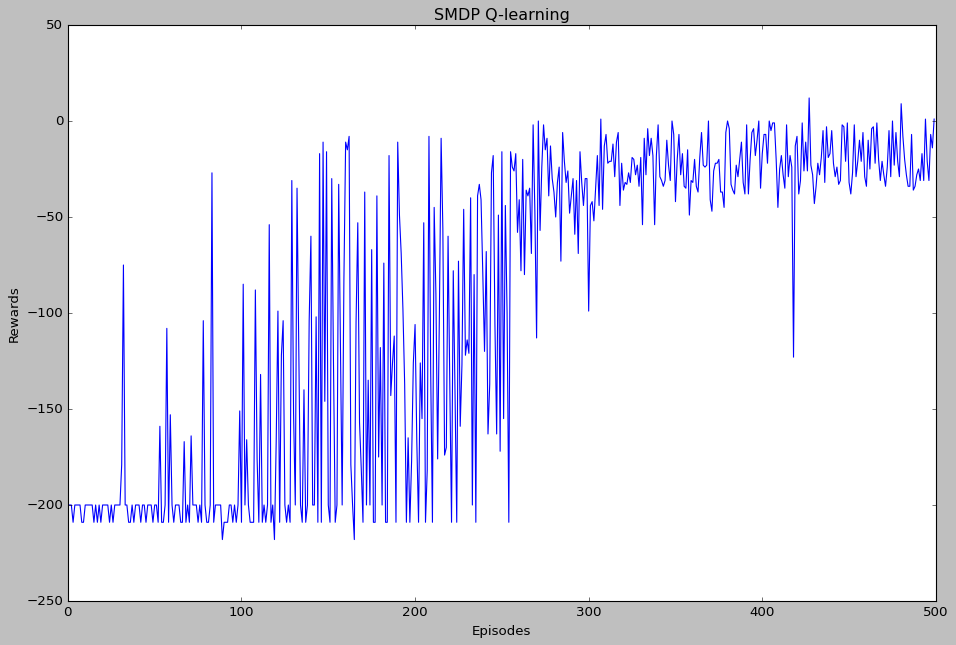

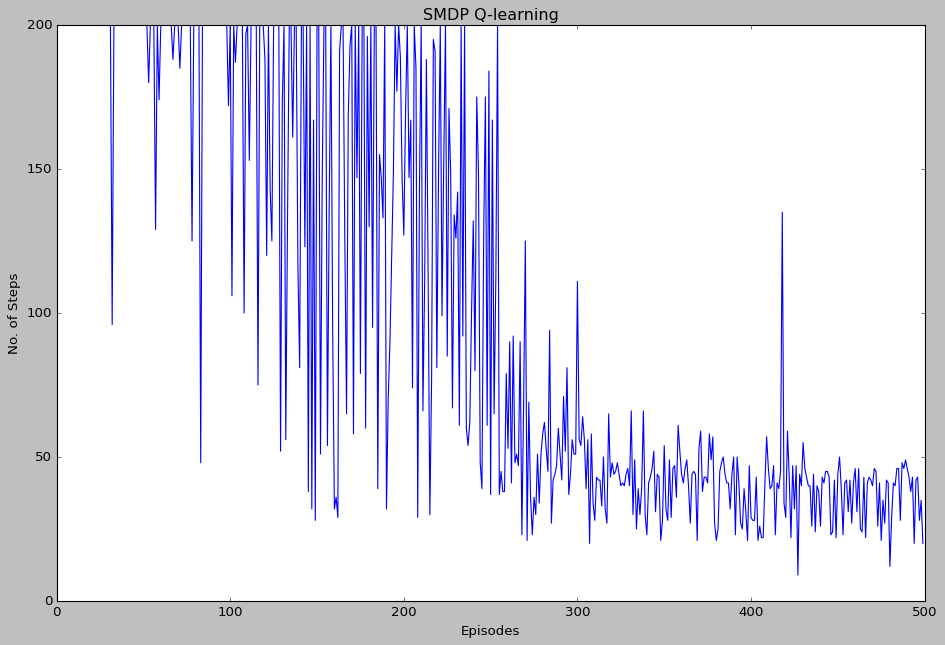

In [38]:
plt.style.use('classic')
plt.figure(figsize = (14,9))
plt.plot(rewards_SMDP)
plt.xlabel('Episodes')
plt.ylabel('Rewards')

plt.title('SMDP Q-learning')

plt.figure(figsize = (14,9))
plt.plot(steps_SMDP)
plt.xlabel('Episodes')
plt.ylabel('No. of Steps')
plt.title('SMDP Q-learning')

In [ ]:
#intra option with 6 options

In [13]:
nPas = 5; nDrop = 4
def Sub(state, nPas = nPas, nDrop = nDrop):
  x,y,pas,drop = env.decode(state)
  if x==2:
    if y==1:
      pres=1
    elif y==3:
      pres=2
    else:
      pres=0
  else:
    pres=0
  subState = (nDrop*pas+drop)*3+pres 
  return subState 

In [14]:
from tqdm import tqdm
rewards_intra_options = []
steps_intra_options = []

gamma = 0.9
alpha = 0.1

nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_intra_option = np.zeros((nPas*nDrop*3,nO)) #Q-values for options
updates_intra_option = np.zeros((nPas*nDrop*3,nO))

#no. of states = 25 and no. actions that moves the taxi = 4
Qopt = [np.zeros((25,4)) for i in range(nO)] #Q-values for primitive actions


eps = 0.01
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

Neps = 500


for i in tqdm(range(Neps)):
    state = env.reset()    
    done = False
    tot_rew = 0
    tot_steps = 0

    
    while not done:
        
        # Choose action  
        x,y,pas,drop = env.decode(state)
        if x==2:
          if y==1:
            pres=1
          elif y==3:
            pres=2
          else:
            pres=0
        else:
          pres=0
        subState = (nDrop*pas+drop)*3+pres
        option = egreedy_policy_smdp(q_values_intra_option, subState, pres, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)
        

        optdone = False
        prev = state
        while not optdone and not done:
            if option==0:
              optact,optdone = Option_0(env,state,Qopt,eps)
            elif option==1:
              optact,optdone = Option_1(env,state,Qopt,eps)
            elif option==2:
              optact,optdone = Option_2(env,state,Qopt,eps)
            elif option==3:
              optact,optdone = Option_3(env,state,Qopt,eps)
            elif option==4:
              optact,optdone = Option_4(env,state,Qopt,eps)
            else:
              optact,optdone = Option_5(env,state,Qopt,eps)
            next_state, reward, done,_ = env.step(optact)
            
            tot_steps += 1

            
            #Option Policy Learning
            [x,y,_,_]=  list(env.decode(state)) 
            [x1,y1,_,_]=  list(env.decode(next_state)) 

            
            tot_rew+=reward
            reward_eff = reward
            if optdone:
              reward_eff = 20
            if optact<4:  
              Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_eff + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])



            #finding all options giving same action call
            
            for o in range(nO):
              if o==0:
                optact_o,optdone_o = Option_0(env,state,Qopt,eps)
              elif o==1:
                optact_o,optdone_o = Option_1(env,state,Qopt,eps)
              elif o==2:
                optact_o,optdone_o = Option_2(env,state,Qopt,eps)
              elif o==3:
                optact_o,optdone_o = Option_3(env,state,Qopt,eps)
              elif o==4:
                optact_o,optdone_o = Option_4(env,state,Qopt,eps)
              else:
                optact_o,optdone_o = Option_5(env,state,Qopt,eps)


              x,y,pas,drop = env.decode(next_state) 
              if x==2:
                if y==1:
                  poss_opt = [0,2]
                elif y==3:
                  poss_opt = [1,3]
                else:
                  poss_opt = [4,5]
              else:
                poss_opt = [4,5]

              x,y,pas,drop = env.decode(state) 
              if x==2:
                if y==1:
                  poss_opt_st = [0,2]
                elif y==3:
                  poss_opt_st = [1,3]
                else:
                  poss_opt_st = [4,5]
              else:
                poss_opt_st = [4,5]
              

              if o in poss_opt_st:
                if optact_o == optact:
                  if optdone_o:
                    q_values_intra_option[Sub(state), o] += alpha*(reward + gamma*np.max([q_values_intra_option[Sub(next_state),poss_opt[0]],q_values_intra_option[Sub(next_state),poss_opt[1]]]) - q_values_intra_option[Sub(state), o])
                  else:
                    if o in poss_opt:
                      q_values_intra_option[Sub(state), o] += alpha*(reward + gamma*q_values_intra_option[Sub(next_state), o] - q_values_intra_option[Sub(state), o]) 

                # updates_intra_option[Sub(state), o] += 1
            state = next_state
        
    rewards_intra_options.append(tot_rew)
    steps_intra_options.append(tot_steps)




100%|██████████| 500/500 [39:04<00:00,  4.69s/it]


Text(0.5, 1.0, 'Intra option Q-learning')

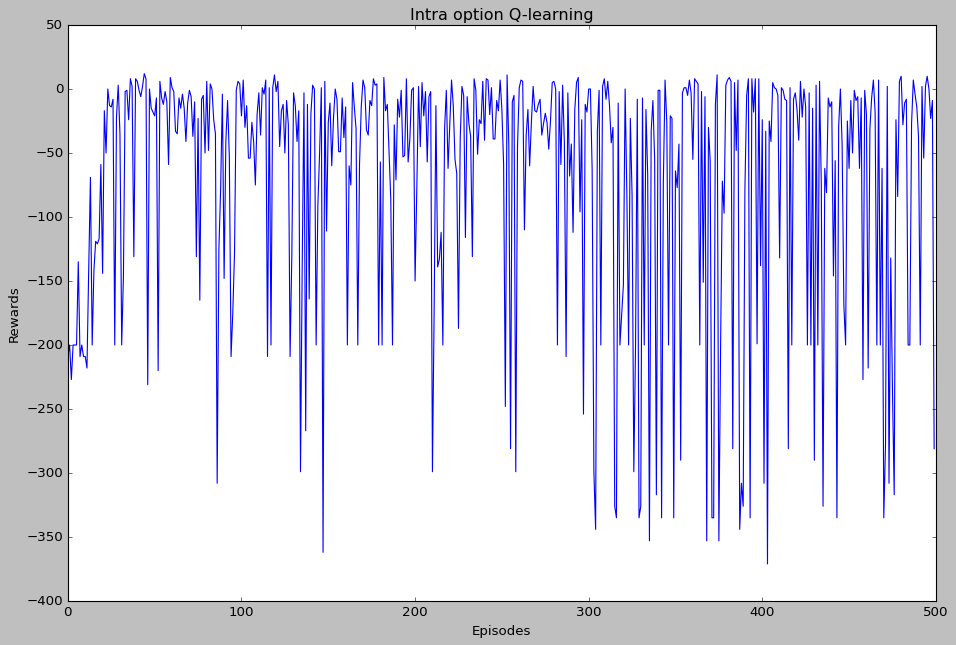

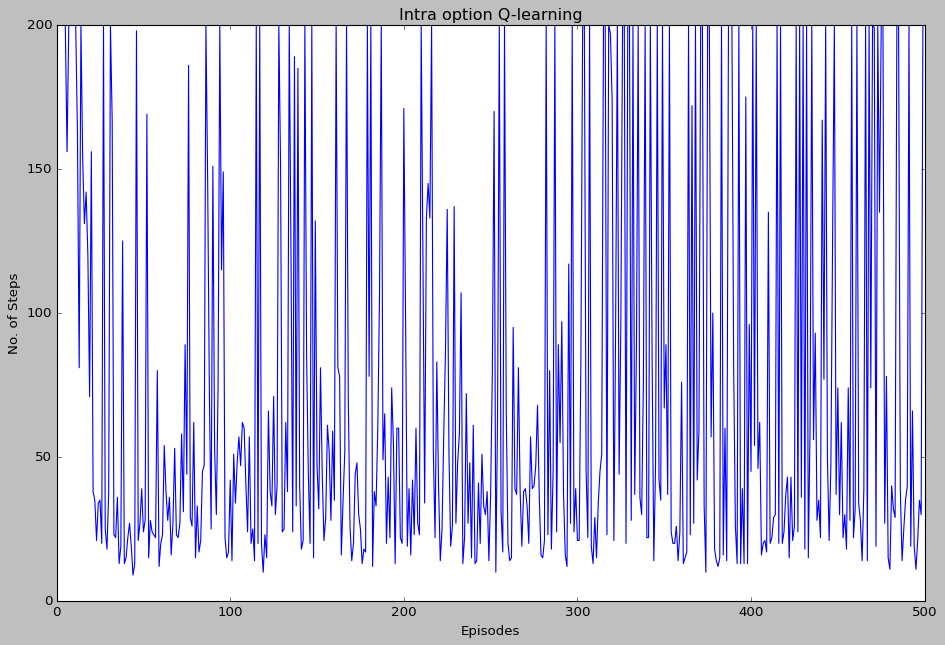

In [15]:
plt.style.use('classic')
plt.figure(figsize = (14,9))
plt.plot(rewards_intra_options)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Intra option Q-learning')

plt.figure(figsize = (14,9))
plt.plot(steps_intra_options)
plt.xlabel('Episodes')
plt.ylabel('No. of Steps')
plt.title('Intra option Q-learning')

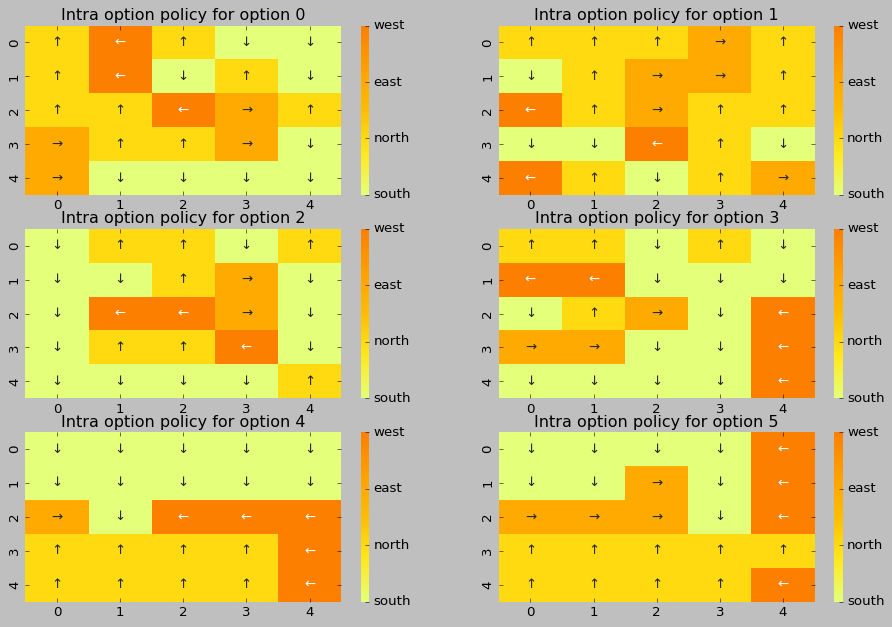

In [19]:
figure, axis = plt.subplots(3,2,figsize=(14,9))
for i in range(3):
  for j in range(2):
    labels = {0:'↓',1:'↑', 2:'→', 3:'←'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='',cmap='Wistia')
    axis[i,j].set_title("Intra option policy for option {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])